In [1]:
%matplotlib inline
# %matplotlib widget

# Plot R by G

In [2]:
import csv
import os
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.facecolor':'white'})

In [3]:
from demapper.code.utils.analyze import extract_dataset, get_all_parameters, plot_results, plot_limits
from demapper.code.utils.config_w3c import DATASETS, FILTERS, get_plot_columns, extract_params_f

circle_loss_threshold = 10.0

In [6]:
# PICKED_DATASET = 'ss_w3cv3'
PICKED_DATASET = 'ss_w3cv5'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)


all_sbjs, sbjs_map = get_all_parameters(df, PICKED_DATASET)

print(max_values)
df.sample(5)

len(stats):  10080
len(results):  10080
Total 14 subjects:
SBJ20
SBJ20-50.0
SBJ20-75.0
SBJ20-83.0
SBJ21
SBJ40
SBJ40-50.0
SBJ40-75.0
SBJ40-83.0
SBJ41
SBJ99
SBJ99-50.0
SBJ99-75.0
SBJ99-83.0
Extra combinations:
SBJ2x : ['SBJ20', 'SBJ21']
SBJ4x : ['SBJ40', 'SBJ41', 'SBJ42', 'SBJ43']
SBJxx-50 : ['SBJ20-50.0', 'SBJ40-50.0', 'SBJ99-50.0']
SBJxx-75 : ['SBJ20-75.0', 'SBJ40-75.0', 'SBJ99-75.0']
SBJxx-83 : ['SBJ20-83.0', 'SBJ40-83.0', 'SBJ99-83.0']
SBJxx-99 : ['SBJ20', 'SBJ40', 'SBJ99']
{'CircleLoss': 53.699999999999996, 'TransitionBetweeness': 28.5}


,Mapper,SBJ,preptype,dist,K,R,G,linkbins,CircleLoss,TransitionBetweeness,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
1093,CustomBDLMapper_PCA_cityblock_16_10_55_10,SBJ20-50.0,PCA,cityblock,16,10,55,10,0.533333,1.0,1.000000,1.000000,0.584615,8.0,3.05856,0.372066,27.9916,3.82018
5979,CustomBDLMapper_none_chebychev_48_30_55_20,SBJ20-50.0,none,chebychev,48,30,55,20,53.700000,28.5,0.370143,0.453782,0.231084,16.0,3.32546,0.056199,86.3938,6.66706
6591,CustomBDLMapper_none_cityblock_32_10_70_10,SBJ99-50.0,none,cityblock,32,10,70,10,0.218182,0.0,1.000000,1.000000,0.594937,6.0,2.65229,0.534773,56.9568,4.79352
7009,CustomBDLMapper_none_cityblock_48_30_70_10,SBJ41,none,cityblock,48,30,70,10,53.700000,28.5,0.564626,0.593281,0.663265,15.0,3.53649,0.540756,228.1280,6.21109
1791,CustomBDLMapper_PCA_cityblock_48_10_55_20,SBJ99-83.0,PCA,cityblock,48,10,55,20,1.000000,2.0,1.000000,1.000000,0.349057,8.0,2.96145,0.191937,42.5141,4.40962


In [34]:

target_metrics = ['CircleLossRev', 'TransitionBetweenessRev', 'coverage_nodes', 'hrfdur_stat', 'distances_entropy']
log_metrics = ['CircleLossRev', 'TransitionBetweenessRev']

df['CircleLossRev'] = df.apply(lambda x: 1.0 / x['CircleLoss'] if x['CircleLoss'] > 0 else 100, axis=1)
df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)

plot_results(df, 'SBJ99_KRG', ['SBJ99'], 'K', 'R', 'G', target_metrics, log_metrics, resdir=resdir)


In [35]:
# Plot limits

target_metrics = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99],
    'coverage_nodes': [0.7, 1.0],
#     'hrfdur_stat': [0.15, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

plot_limits(df, 'SBJ99_KRG', ['SBJ99'], 'K', 'R', 'G', target_metrics, resdir=resdir)

In [36]:
fullname = {
    'R': 'Resolution',
    'G': 'Gain'
}


target_metrics = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99],
    'coverage_nodes': [0.7, 1.0],
#     'hrfdur_stat': [0.15, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

def plot_merger(df, sbj_group_name, sbj_group, fixedV, fixedVals, indexV, colV, target_metrics, resdir):
    df, fixedV = _handle_list_cols(df, fixedV)
    df, indexV = _handle_list_cols(df, indexV)
    df, colV = _handle_list_cols(df, colV)

    newtypes = {}
    allcols = []
    for col in [fixedV, indexV, colV]:
        col = col if type(col) == list else [col]
        allcols.extend(col)
        for c in col:
            if c in ['K', 'G', 'R', 'linkbins']:
                newtypes[c] = 'int'

    df_filter = df['SBJ'] == sbj_group[0]
    for idx in range(1,len(sbj_group)):
        df_filter = df_filter | (df['SBJ'] == sbj_group[idx])

    dff = df[df_filter]
    dff = dff.groupby(['Mapper'] + allcols).mean()
    dff = dff.reset_index().astype(newtypes)

    fixed_vals = sorted(list(set(df[fixedV].to_list())))
    # Create combs
    combs = []
    for col_idx,K in enumerate(fixed_vals):
        comb_isset = False
        df_comb = None
        for target, lims in target_metrics.items():
            df_p = dff[dff[fixedV] == K].pivot(index=indexV, columns=colV, values=target)
            df_wl = (df_p >= lims[0]) & (df_p <= lims[1]) # within limits
            if not comb_isset:
                df_comb = df_wl
                comb_isset = True
            else:
                df_comb = df_comb & df_wl

        combs.append(df_comb)
        
    iV = combs[0].index.to_list()
    cV = combs[0].columns.to_list()
    added = np.zeros_like(combs[0].to_numpy())

    cnt = 0
    for k,fV in enumerate(fixed_vals):
        if fV in fixedVals:
            M = combs[k].to_numpy() * 1
#             print(fV, added.shape, M.shape)
            added = added + M
            cnt += 1

    ax = sns.heatmap(np.flip(added / cnt, 0), xticklabels=cV, yticklabels=iV[::-1], vmax=1.0)
    ax.set_ylabel(fullname[indexV])
    ax.set_xlabel(fullname[colV])
    plt.tight_layout()
    plt.savefig(os.path.join(resdir,'plot_merger{}{}_{}.png'.format(indexV, colV, sbj_group_name)), dpi=150)
    plt.close()


In [37]:

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    fixedV = 'K'
    fixedVals = [10, 20, 30, 40, 50, 60, 70] # for NeuMapper and BDLMapper
    plot_merger(df, sbj_group_name, sbj_group, fixedV, fixedVals, 'R', 'G', target_metrics, resdir=resdir)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.62it/s]


,Mapper,SBJ,K,R,G,CircleLoss,TransitionBetweeness,mapper,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy,CircleLossRev,TransitionBetweenessRev
0,NeuMapper_100_100_25,SBJ20,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.553957,0.584883,0.460432,20.0,3.80631,0.022352,28.5225,5.93724,0.016574,0.181818
1,NeuMapper_100_100_25,SBJ20-50.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.264706,0.403361,0.264706,10.0,2.69076,0.084638,16.2809,5.24022,0.016574,0.181818
2,NeuMapper_100_100_25,SBJ20-75.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.409091,0.440000,0.393939,16.0,3.55220,0.075818,24.9488,5.78353,0.016574,0.181818
3,NeuMapper_100_100_25,SBJ20-83.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.458015,0.499638,0.404580,17.0,3.48939,0.156666,34.5293,6.26467,0.016574,0.181818
4,NeuMapper_100_100_25,SBJ21,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.400000,0.538692,0.453846,11.0,3.11294,0.063801,32.7115,6.17703,0.016574,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,NeuMapper_80_50_75,SBJ41,80,50,75,0.444444,4.5,NeuMapper_80_50_75,1.000000,1.000000,1.000000,3.0,1.43237,0.096786,374.9180,4.92024,2.250000,0.181818
11756,NeuMapper_80_50_75,SBJ99,80,50,75,0.092437,4.5,NeuMapper_80_50_75,1.000000,1.000000,0.962264,3.0,1.57309,0.232076,298.6230,3.93364,10.818182,0.181818
11757,NeuMapper_80_50_75,SBJ99-50.0,80,50,75,0.133333,0.0,NeuMapper_80_50_75,1.000000,1.000000,0.903846,4.0,1.89020,0.064162,230.0550,3.91960,7.500000,1.000000
11758,NeuMapper_80_50_75,SBJ99-75.0,80,50,75,0.076923,0.0,NeuMapper_80_50_75,1.000000,1.000000,0.888889,4.0,1.76498,0.138503,240.1440,4.30888,13.000000,1.000000


In [31]:

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    fixedV = 'K'
    fixedVals = [10, 20, 30, 40, 50, 60, 70]
    dff = df[df['R'] <= 500]
    plot_merger(dff, sbj_group_name, sbj_group, fixedV, fixedVals, 'G', 'R', target_metrics, resdir=resdir)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.37it/s]


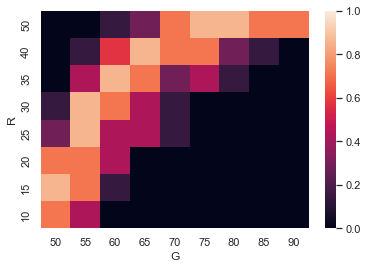

In [79]:
fixedV = 'K'
fixedVals = [10, 20, 30, 40, 50, 60, 70]
plot_merger(df, 'SBJ99_KRG', ['SBJ41'], fixedV, fixedVals, 'R', 'G', target_metrics, resdir=resdir)

In [ ]:

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    fixedV = 'K'
    fixedVals = [10, 20, 30, 40, 50, 60, 70] # for NeuMapper and BDLMapper
    plot_merger(df, sbj_group_name, sbj_group, fixedV, fixedVals, 'R', 'G', target_metrics, resdir=resdir)

<AxesSubplot:>

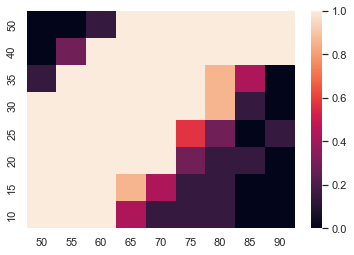

In [45]:
sns.heatmap(np.flip(added / cnt, 1), xticklabels=G, yticklabels=R[::-1])

array([[ True,  True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True]])